In [49]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pydicom, cv2, torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

Cohort Exploration

In [50]:
patient_df = pd.read_csv('/Users/jiwoo_noh/Downloads/admissions.csv')
dicom_df   = pd.read_csv('/Users/jiwoo_noh/Downloads/cxr-record-list.csv')

dicom_filtered = dicom_df[
    dicom_df['subject_id'].astype(str).str.startswith(('10', '11', '12', '13'))
]

merged = dicom_filtered.merge(
    patient_df[['subject_id', 'ethnicity']],
    on='subject_id',
    how='left'
)

to_drop = ['OTHER', 'UNKNOWN', 'UNABLE TO OBTAIN']
merged = merged[~merged['ethnicity'].isin(to_drop)]

result = merged[['subject_id', 'ethnicity', 'path']]

print(result.head())

result.to_csv(
    '/Users/jiwoo_noh/Downloads/patient_ethnicity_with_path.csv',
    index=False
)


   subject_id ethnicity                                               path
0    10000032     WHITE  files/p10/p10000032/s50414267/02aa804e-bde0afd...
1    10000032     WHITE  files/p10/p10000032/s50414267/02aa804e-bde0afd...
2    10000032     WHITE  files/p10/p10000032/s50414267/02aa804e-bde0afd...
3    10000032     WHITE  files/p10/p10000032/s50414267/02aa804e-bde0afd...
4    10000032     WHITE  files/p10/p10000032/s50414267/174413ec-4ec4c1f...


In [56]:
labels_df = pd.read_csv('/Users/jiwoo_noh/Downloads/patient_ethnicity_with_path.csv')

eth_df = labels_df[['subject_id','ethnicity']].drop_duplicates()
counts = eth_df['subject_id'].value_counts()
ambiguous_ids = counts[counts > 1].index.tolist()

if ambiguous_ids:
    print(f"Removing {len(ambiguous_ids)} patients with inconsistent ethnicity:", ambiguous_ids)

labels_df = labels_df[~labels_df['subject_id'].isin(ambiguous_ids)].reset_index(drop=True)
labels = labels_df['ethnicity']
subject_id = labels_df['subject_id']

Removing 169 patients with inconsistent ethnicity: [13166511, 13647995, 13413901, 10253747, 11924512, 13025966, 12450853, 11319919, 10190829, 11312381, 13881858, 12891356, 12493668, 12546830, 11955908, 13516267, 13042039, 11608914, 10413587, 11659237, 11051429, 13721087, 11900468, 12034618, 10798787, 12903377, 13358134, 12697173, 10284192, 11285537, 13382305, 12604466, 11937117, 10731206, 10101795, 10942097, 12547294, 12326925, 10827166, 10155734, 12286923, 13852963, 13383377, 12916923, 12807740, 13961572, 13150918, 10367781, 13440918, 12077819, 13281197, 11408332, 13228076, 11906175, 12104123, 12297145, 10604743, 10242587, 12704996, 13282748, 10575262, 11617122, 10670705, 13224214, 13582085, 10792610, 11242742, 13465969, 12565496, 13843470, 11619714, 13824839, 11668016, 12847427, 11742857, 11138817, 12160760, 11401186, 13775723, 12673327, 12125322, 10483958, 10916975, 12250460, 13287790, 13964931, 13222436, 13823428, 11925631, 11480454, 13965801, 12106493, 11845541, 13705993, 10056612

In [57]:
# calculate data demographics
race_counts = labels_df['ethnicity'].value_counts()
print(race_counts)

print(len(subject_id))

ethnicity
WHITE                            630245
BLACK/AFRICAN AMERICAN           230747
HISPANIC/LATINO                   86697
ASIAN                             17664
AMERICAN INDIAN/ALASKA NATIVE      1824
Name: count, dtype: int64
979032


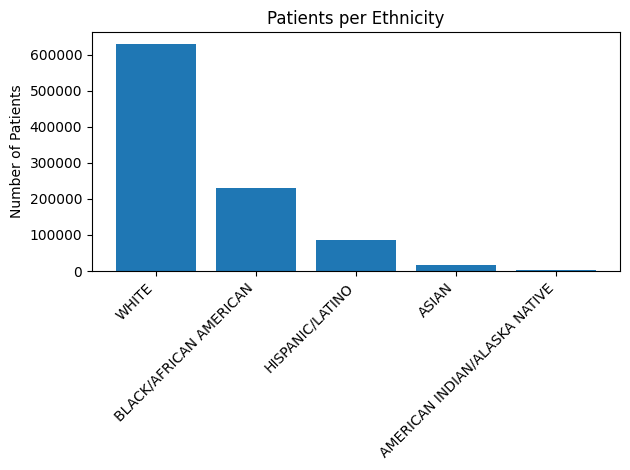

In [58]:
# plotting race distribution
plt.figure()
plt.bar(race_counts.index, race_counts.values)
plt.ylabel('Number of Patients')
plt.title('Patients per Ethnicity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

DICOM Preprocessing

In [62]:
# preprocessing and generating model inputs
# need the local file structure that each patient id head is within
local_path_stem = '/Users/jiwoo_noh/Downloads/physionet.org/files/mimic-cxr/2.1.0/'

valid_rows = []
images_dict = {}
labels_dict = {}

for _, row in labels_df.iterrows():
    patient_id = row['subject_id']
    full_path  = os.path.join(local_path_stem, row['path'])
    if not os.path.exists(full_path):
        continue

    try:
        #img_tensor = preprocess_dicom_to_tensor(full_path, transform)
        #images_dict[(patient_id, full_path)] = img_tensor
        labels_dict[(patient_id, full_path)] = row['ethnicity']

        # record this row with full_path for your valid_df
        new_row = row.copy()
        new_row['path'] = full_path
        valid_rows.append(new_row)

    except Exception as e:
        print(f"error loading {full_path}: {e}")

# save the new list of patients (this is the data we will actually have access to)
valid_df = pd.DataFrame(valid_rows)
valid_df.to_csv('downloaded_data_info.csv', index=False)

ethnicity
BLACK/AFRICAN AMERICAN    1745
WHITE                     1170
ASIAN                       35
Name: count, dtype: int64
Number of unique patients:51


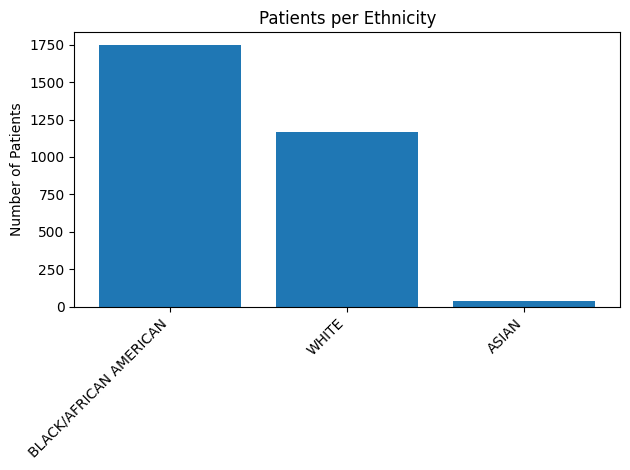

In [64]:
## plot the final patient demographics after filtering and downloading
race_counts = valid_df['ethnicity'].value_counts()
print(race_counts)

unique_subject = valid_df['subject_id'].unique()

print(f'Number of unique patients:{len(unique_subject)}')

plt.figure()
plt.bar(race_counts.index, race_counts.values)
plt.ylabel('Number of Patients')
plt.title('Patients per Ethnicity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# by patient train/validation/test split
# stratified by ethnicity
patient_labels = valid_df.groupby('subject_id')['ethnicity'].first()
unique_patients = patient_labels.index.tolist()
patient_label_list = patient_labels.tolist()

# 80 train, val 10, test 10
train_patients, temp_patients = train_test_split(unique_patients, test_size = 0.2, stratify=patient_label_list, random_state = 42)
temp_labels = patient_labels.loc[temp_patients].tolist()
val_patients, test_patients = train_test_split(temp_patients, test_size = 0.5, stratify=temp_labels, random_state = 42)

print(f'Train size: {train_patients.size}')
print(f'Val size: {val_patients.size}')
print(f'Test size: {test_patients.size}')

# complete training, validation, testing datasets because patients have more than one dicom
train_items = []
val_items = []
test_items = []

for (patient_id, path) in labels_dict.keys():
    if patient_id in train_patients:
        train_items.append((patient_id, path))
    elif patient_id in val_patients:
        val_items.append((patient_id, path))
    elif patient_id in test_patients:
        test_items.append((patient_id, path))
    else:
        print("Patient ID: {patient_id} not found in any split but is in the processed images. Something is seriously wrong. Taco.")

# output lists of patient, path pairs as keys
# need to have labels_dict dictionary loaded in --> tensors as items in this dictionary

In [ ]:
class LazyDicomDataset(Dataset):
    def __init__(self, items, labels_dict, transform=None):
        """
        items:     list of (patient_id, full_path) tuples
        labels_dict: dict mapping (patient_id, full_path) -> label
        transform: optional image transformation
        """
        self.items = items
        self.labels = labels_dict
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        patient_id, full_path = self.items[idx]
        # load & preprocess here:
        image_tensor = preprocess_dicom_to_tensor(full_path, self.transform)
        label = self.labels[(patient_id, full_path)]
        return image_tensor, label


stats_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),   # floats in [0,1]
])

# Build a temporary Dataset & DataLoader for stats
stats_ds = LazyDicomDataset(train_items, labels_dict, transform=stats_transform)
stats_loader = DataLoader(stats_ds, batch_size=32, shuffle=False, num_workers=4)

# Accumulate channel sums
channel_sum = 0.0
channel_sq_sum = 0.0
num_pixels = 0

for imgs, _ in stats_loader:
    # imgs shape [B, C, H, W]; here C=1
    channel_sum    += imgs.sum()
    channel_sq_sum += (imgs ** 2).sum()
    num_pixels     += imgs.numel()

mean = (channel_sum / num_pixels).item()
var  = (channel_sq_sum / num_pixels - mean**2).item()
std  = np.sqrt(var)

print(f"Computed dataset mean={mean:.4f}, std={std:.4f}")

# --- 2) Now define your final transform with the computed Normalize ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  
    transforms.Normalize(mean=[mean], std=[std]),
])

# --- 3) Your existing helper stays the same ---
def preprocess_dicom_to_tensor(dcm_path, transform):
    ds  = pydicom.dcmread(dcm_path)
    arr = ds.pixel_array.astype(np.float32)
    arr = (arr - arr.min()) / (arr.ptp() + 1e-6)
    arr = (arr * 255.0).astype(np.uint8)
    img = Image.fromarray(arr)    
    return transform(img)

In [ ]:
# # optionally define a normalize/augment function
# def normalize(tensor):
#     tensor = tensor - tensor.min()
#     tensor = tensor / tensor.max()
#     return tensor

train_ds = LazyDicomDataset(train_items, labels_dict, transform=transform)
val_ds   = LazyDicomDataset(val_items,   labels_dict, transform=transform)
test_ds  = LazyDicomDataset(test_items,  labels_dict, transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import densenet121
from tqdm import tqdm

# --- 1) Setup device and derive classes from your labels_dict ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# labels_dict maps (patient_id, path) -> ethnicity string
unique_labels = sorted(set(labels_dict.values()))
label2idx = {lab: idx for idx, lab in enumerate(unique_labels)}
num_classes = len(unique_labels)
print(f"Detected classes: {unique_labels} → {num_classes} total")

# --- 2) Initialize DenseNet121 ---
model = densenet121(pretrained=True)
# Replace classifier with output size == num_classes
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model = model.to(device)

# --- 3) Loss, optimizer, scheduler ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# --- 4) Training loop ---
num_epochs = 20
best_val_acc = 0.0

for epoch in range(1, num_epochs+1):
    # -- Train --
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]"):
        images = images.to(device)
        # labels is list of ethnicity strings → map to ints
        labels = torch.tensor([label2idx[l] for l in labels], dtype=torch.long, device=device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
    
    train_loss /= train_total
    train_acc = train_correct / train_total
    
    # -- Validate --
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} [Val]"):
            images = images.to(device)
            labels = torch.tensor([label2idx[l] for l in labels], dtype=torch.long, device=device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_loss /= val_total
    val_acc = val_correct / val_total
    
    scheduler.step()
    
    print(f"\nEpoch {epoch}/{num_epochs} — "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_densenet_race.pth")
        print("→ New best model saved")
    print("-" * 60)

print(f"Training complete. Best Val Acc: {best_val_acc:.4f}")
